### - Sobhan Moradian Daghigh
#### - 5/29/2022
#### - ANN - HW06

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import urllib
import pickle
from sklearn.metrics import confusion_matrix

import tensorflow as tf, keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, LSTM, Dropout

import warnings
warnings.filterwarnings("ignore")

import itertools

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [5]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = np.inf
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get('loss')
    if np.less(current_loss, self.best):
      self.best = current_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [6]:
es_callback = EarlyStoppingCallback(patience=3)

# Load Data

In [233]:
def load_data(base_url):
  datas = []
  data_for_plot = []
  file_names = []

  with urllib.request.urlopen(base_url + 'names.txt') as names:
    idx = 0
    for name in names.readlines():
      name = name.decode("utf-8").split('\n')[0]
      data = pd.read_csv(base_url + name, delimiter=',', encoding='utf-16-le')
      if not data.empty:

        data = pd.DataFrame(data[(data['<DTYYYYMMDD>'] > 20210522)], columns=data.columns) # Filter 1 year
        # new_data = pd.DataFrame(columns=['DATA','CLOSE'])
        # new_data['DATA'] = data.loc[:, '<DTYYYYMMDD>']
        # new_data['CLOSE'] = data.loc[:, '<CLOSE>']

        datas.append(data)
        data_for_plot.append(data)
        file_names.append(name)
        print('   |_ {}- {} loaded.'.format(idx, name))
        idx += 1

  return datas, data_for_plot, file_names

In [234]:
base_url = 'https://raw.githubusercontent.com/nahbos/AUT-Neural-Networks/main/HW06/dataset/'
datas, data_for_plot, names = load_data(base_url)

   |_ 0- IRX6XAFF0005.csv loaded.
   |_ 1- IRX6XALS0002.csv loaded.
   |_ 2- IRX6XS300003.csv loaded.
   |_ 3- IRX6XSLC0000.csv loaded.
   |_ 4- IRX6XSNT0009.csv loaded.
   |_ 5- IRX6XTAL0001.csv loaded.
   |_ 6- IRX6XTPI0009[2022-05-23-10-18-57].csv loaded.
   |_ 7- IRX6XTPI0025.csv loaded.
   |_ 8- IRX6XWAI0001.csv loaded.
   |_ 9- IRXYXTPI0009.csv loaded.
   |_ 10- IRXYXTPI0025.csv loaded.
   |_ 11- IRXZXCMI0000.csv loaded.
   |_ 12- IRXZXENG0009.csv loaded.
   |_ 13- IRXZXOBM0003.csv loaded.
   |_ 14- IRXZXOCI0008.csv loaded.
   |_ 15- IRXZXTRI0006.csv loaded.
   |_ 16- IRXZXWDI0007.csv loaded.


In [343]:
datas[11].shape

(237, 13)

In [235]:
total_index = names.index('IRX6XTPI0009[2022-05-23-10-18-57].csv')
demo = datas[total_index]
demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 3005 to 3218
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <TICKER>      214 non-null    object 
 1   <DTYYYYMMDD>  214 non-null    int64  
 2   <OPEN>        214 non-null    float64
 3   <HIGH>        214 non-null    float64
 4   <LOW>         214 non-null    float64
 5   <CLOSE>       214 non-null    float64
 6   <VOL>         214 non-null    int64  
 7   <OPENINT>     214 non-null    float64
 8   <OPENINT>.1   214 non-null    int64  
 9   <OPENINT>.2   214 non-null    float64
 10  <LAST>        214 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 20.1+ KB


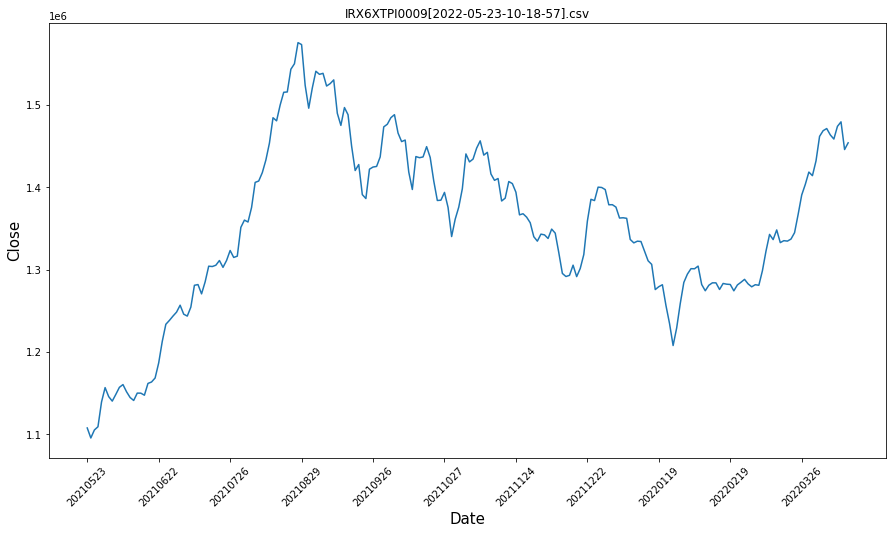

In [236]:
plt.figure(figsize = (15, 8))
plt.plot(range(data_for_plot[total_index].shape[0]), data_for_plot[total_index]['<CLOSE>'])
plt.xticks(range(0, data_for_plot[total_index].shape[0], 20), data_for_plot[total_index]['<DTYYYYMMDD>'].loc[::20], rotation=45)
plt.title(names[total_index])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.show()

In [237]:
demo.shape

(214, 11)

## Data Normalization

In [278]:
scaled_datas = []
for csv in datas:
  attrs = [2, 5]
  headers = csv.columns[attrs]
  temp = csv.iloc[:, csv.columns.isin(headers)]
  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = pd.DataFrame(scaler.fit_transform(temp), columns=headers)
  scaled_datas.append(data_scaled)

In [279]:
scaled_datas[0]

,<OPEN>,<CLOSE>
0,0.091317,0.080904
1,0.062991,0.058539
2,0.044696,0.071131
3,0.058803,0.075627
4,0.066556,0.121028
...,...,...
233,0.631875,0.653906
234,0.661347,0.682359
235,0.675354,0.659002
236,0.646462,0.638661


## Define time steps

In [310]:
x_train_val_timesteps = []
y_train_val_timesteps = []

x_test = []
y_test = []

timesteps_size = 10

for i, training_data in enumerate(scaled_datas):
  if i != total_index:
    for i in range(training_data.shape[0] - timesteps_size):
      x_train_val_timesteps.append(training_data.to_numpy()[i:i + timesteps_size, :])

      if training_data.loc[i + timesteps_size, '<CLOSE>'] > training_data.loc[i + timesteps_size - 1, '<CLOSE>']:
        y_train_val_timesteps.append(1)
      else:
        y_train_val_timesteps.append(0)
    
  else:
    for i in range(training_data.shape[0] - timesteps_size):
      x_test.append(training_data.to_numpy()[i:i + timesteps_size, :])

      if training_data.loc[i + timesteps_size, '<CLOSE>'] > training_data.loc[i + timesteps_size - 1, '<CLOSE>']:
        y_test.append(1)
      else:
        y_test.append(0)
    

x_train_val_timesteps, y_train_val_timesteps = np.array(x_train_val_timesteps), np.array(y_train_val_timesteps)
x_train_val_timesteps = np.reshape(x_train_val_timesteps, (x_train_val_timesteps.shape[0], x_train_val_timesteps.shape[1], data_scaled.shape[1]))

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], data_scaled.shape[1]))

x_train, x_val, y_train, y_val = train_test_split(x_train_val_timesteps, y_train_val_timesteps, test_size=0.1, random_state=0)

In [313]:
x_train.shape

(3076, 10, 2)

In [314]:
x_val.shape

(342, 10, 2)

In [315]:
x_test.shape

(204, 10, 2)

## LSTM

In [324]:
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
# model.add(Dropout(0.1)) 
# model.add(LSTM(units=50))
# model.add(Dense(1))

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units=70,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=20))
model.add(Dense(units=1))




In [325]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_98 (LSTM)              (None, 10, 100)           41200     
                                                                 
 dropout_59 (Dropout)        (None, 10, 100)           0         
                                                                 
 lstm_99 (LSTM)              (None, 10, 70)            47880     
                                                                 
 dropout_60 (Dropout)        (None, 10, 70)            0         
                                                                 
 lstm_100 (LSTM)             (None, 10, 50)            24200     
                                                                 
 dropout_61 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_101 (LSTM)             (None, 20)              

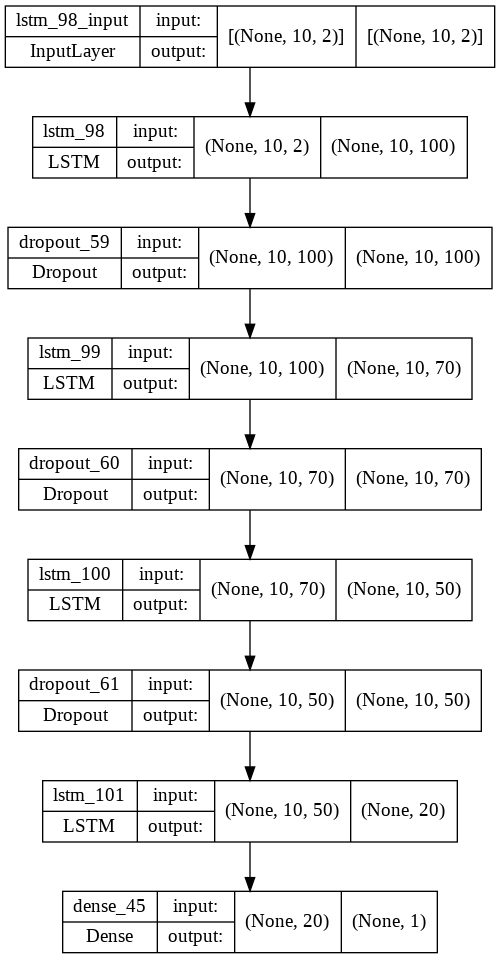

In [326]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [327]:
model.fit(x_train, y_train, batch_size=32, epochs=1000, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/1000
97/97 [==============================] - 14s 54ms/step - loss: 0.8232 - accuracy: 0.4701 - val_loss: 0.7340 - val_accuracy: 0.4415
Epoch 2/1000
97/97 [==============================] - 3s 35ms/step - loss: 0.7102 - accuracy: 0.4789 - val_loss: 0.7020 - val_accuracy: 0.5263
Epoch 3/1000
97/97 [==============================] - 3s 35ms/step - loss: 0.6972 - accuracy: 0.5081 - val_loss: 0.6850 - val_accuracy: 0.5614
Epoch 4/1000
97/97 [==============================] - 3s 34ms/step - loss: 0.6939 - accuracy: 0.5296 - val_loss: 0.6840 - val_accuracy: 0.5614
Epoch 5/1000
97/97 [==============================] - 3s 35ms/step - loss: 0.6926 - accuracy: 0.5283 - val_loss: 0.6866 - val_accuracy: 0.5673
Epoch 6/1000
97/97 [==============================] - 3s 36ms/step - loss: 0.6898 - accuracy: 0.5361 - val_loss: 0.6857 - val_accuracy: 0.5322
Epoch 7/1000
97/97 [==============================] - 3s 35ms/step - loss: 0.6930 - accuracy: 0.5234 - val_loss: 0.6837 - val_accuracy: 0.581

In [328]:
model.evaluate(x_test, y_test, verbose=1)

7/7 [==============================] - 0s 11ms/step - loss: 0.5236 - accuracy: 0.7402


[0.5236175656318665, 0.7401960492134094]

In [344]:
# %tensorboard --logdir '/content/drive/MyDrive/logs'

In [333]:
# filename = '/content/drive/MyDrive/model.sav'
# pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://f5125db2-2310-4277-89f7-bcc105e741dc/assets


INFO:tensorflow:Assets written to: ram://f5125db2-2310-4277-89f7-bcc105e741dc/assets


In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))

# Confusion Matrix

In [339]:
y_pred = model.predict(x_test)
oo = [1 if x > 0.5 else 0 for x in y_pred]
confusion_matrix(y_test, oo)

array([[57, 32],
       [21, 94]])

## GRU

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, return_sequences=True, input_shape=(20, 320), activation='tanh'))
model.add(tf.keras.layers.GRU(50,activation='tanh'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,decay=1e-7,momentum=0.9,nesterov=False),loss='binary_crossentropy')
print(model.summary())